### Decision Tree Model for Wildfire Prediction

Based on entropy analysis from combined.ipynb:

**Top Features by Information Gain:**
1. NOx_ppb: 0.150431 (Best first split)
2. PM25_ugm3: 0.136348 
3. PressureAnomaly1: 0.022422
4. Avg_Pressure_in: 0.022422
5. Avg_Temp_F: 0.018999

**Features to DROP:**
- CO2_ppm (least accurate information)
- Date (not a predictive feature)
- City, Climate (categorical, low predictive power)
- pm2.5 difference (derived feature, redundant)
- dispersion_ratio (non-numeric issues)


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Load the interpolated dataset
df = pd.read_csv("/home/aveb7tacoma/engr697/data/combined_interpolated.csv")
df['Date'] = pd.to_datetime(df['Date'])

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nTarget variable distribution:")
print(df['yn'].value_counts())
print(f"\nTarget variable percentage:")
print(df['yn'].value_counts(normalize=True) * 100)


Dataset loaded successfully!
Shape: (276, 23)

Target variable distribution:
yn
0    162
1    114
Name: count, dtype: int64

Target variable percentage:
yn
0    58.695652
1    41.304348
Name: proportion, dtype: float64


In [38]:

# Use the interpolated dataset (already has missing values filled)
df = pd.read_csv("/home/aveb7tacoma/engr697/data/combined_interpolated.csv")
df['Date'] = pd.to_datetime(df['Date'])

# Define features to USE and DROP based on entropy analysis
# Features to DROP (low information gain, inaccurate, or non-predictive)
features_to_drop = [
    'Date',           # Not predictive
    'City',          # Categorical, low predictive power
    'Climate',       # Categorical, low predictive power  
    'CO2_ppm',       # Least accurate information
    'pm2.5 difference',  # Derived feature, redundant
    'dispersion_ratio'   # Non-numeric issues
]

# Features to USE (based on entropy analysis ranking)
# Top features by information gain:
features_to_use = [
    'NOx_ppb',              # Rank 1: Info Gain = 0.150431
    'PM25_ugm3',            # Rank 2: Info Gain = 0.136348
    'PressureAnomaly1',     # Rank 3: Info Gain = 0.022422
    'Avg_Pressure_in',      # Rank 4: Info Gain = 0.022422
    'Avg_Temp_F',           # Rank 5: Info Gain = 0.018999
    'Min_Temp_F',           # Rank 6: Info Gain = 0.016104
    'Max_Humidity_',        # Rank 7: Info Gain = 0.013203
    'Min_Pressure_in',      # Rank 8: Info Gain = 0.010201
    'Max_Pressure_in',      # Rank 9: Info Gain = 0.006574
    'Avg_Humidity_',        # Rank 10: Info Gain = 0.005633
    'Min_Humidity_',        # Additional feature
    'Max_Wind_Speed_mph',   # Additional feature
    'Avg_Wind_Speed_mph',   # Additional feature
    'dryness_index '        # Additional feature
]

print("Features Configuration:")
print(f"\nFeatures to DROP ({len(features_to_drop)}):")
for f in features_to_drop:
    print(f"  - {f}")

print(f"\nFeatures to USE ({len(features_to_use)}):")
for i, f in enumerate(features_to_use, 1):
    print(f"  {i:2d}. {f}")

# Prepare features and target
X = df[features_to_use].copy()
y = df['yn'].copy()

# Convert all feature columns to numeric, replacing any non-numeric values with NaN
print(f"\nConverting features to numeric...")
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Handle any missing values
print(f"\nMissing values in features:")
missing = X.isna().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    # Fill missing values with median (only for numeric columns)
    X = X.fillna(X.select_dtypes(include=[np.number]).median())
    print("Filled missing values with median")
else:
    print("No missing values!")

# Ensure all columns are numeric
X = X.select_dtypes(include=[np.number])

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Feature data types:")
print(X.dtypes)


Features Configuration:

Features to DROP (6):
  - Date
  - City
  - Climate
  - CO2_ppm
  - pm2.5 difference
  - dispersion_ratio

Features to USE (14):
   1. NOx_ppb
   2. PM25_ugm3
   3. PressureAnomaly1
   4. Avg_Pressure_in
   5. Avg_Temp_F
   6. Min_Temp_F
   7. Max_Humidity_
   8. Min_Pressure_in
   9. Max_Pressure_in
  10. Avg_Humidity_
  11. Min_Humidity_
  12. Max_Wind_Speed_mph
  13. Avg_Wind_Speed_mph
  14. dryness_index 

Converting features to numeric...

Missing values in features:
NOx_ppb    1
dtype: int64
Filled missing values with median

Feature matrix shape: (276, 14)
Target vector shape: (276,)
Feature data types:
NOx_ppb               float64
PM25_ugm3             float64
PressureAnomaly1      float64
Avg_Pressure_in       float64
Avg_Temp_F            float64
Min_Temp_F              int64
Max_Humidity_           int64
Min_Pressure_in       float64
Max_Pressure_in       float64
Avg_Humidity_         float64
Min_Humidity_           int64
Max_Wind_Speed_mph      int

In [39]:
# Define decision tree layers based on entropy analysis
print("="*80)
print("DECISION TREE ARCHITECTURE")
print("="*80)

print("""
Layer 1 (Root): NOx_ppb
  - Split at median: 0.0330
  - Highest information gain: 0.150431
  - Left branch entropy: 0.7103
  - Right branch entropy: 0.9467

Layer 2 (Left branch): PM25_ugm3
  - Second highest information gain: 0.136348
  - Split at median: 12.25
  
Layer 2 (Right branch): PM25_ugm3
  - Same feature for consistency
  - Split at median: 12.25

Layer 3+: Additional features based on information gain
  - PressureAnomaly1, Avg_Pressure_in, Avg_Temp_F, etc.
""")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())
print(f"\nTest target distribution:")
print(y_test.value_counts())


DECISION TREE ARCHITECTURE

Layer 1 (Root): NOx_ppb
  - Split at median: 0.0330
  - Highest information gain: 0.150431
  - Left branch entropy: 0.7103
  - Right branch entropy: 0.9467

Layer 2 (Left branch): PM25_ugm3
  - Second highest information gain: 0.136348
  - Split at median: 12.25

Layer 2 (Right branch): PM25_ugm3
  - Same feature for consistency
  - Split at median: 12.25

Layer 3+: Additional features based on information gain
  - PressureAnomaly1, Avg_Pressure_in, Avg_Temp_F, etc.


Training set: (220, 14)
Test set: (56, 14)

Training target distribution:
yn
0    129
1     91
Name: count, dtype: int64

Test target distribution:
yn
0    33
1    23
Name: count, dtype: int64


In [40]:
# Build decision tree with parameters based on entropy analysis
# Use max_depth to control tree complexity
# Feature importance should align with information gain ranking

dt_model = DecisionTreeClassifier(
    criterion='entropy',           # Use entropy (same as our analysis)
    max_depth=4,                   # Limit depth to prevent overfitting
    min_samples_split=10,          # Minimum samples to split
    min_samples_leaf=5,            # Minimum samples in leaf
    random_state=42,
    class_weight='balanced'        # Handle class imbalance
)

# Train the model
print("Training decision tree model...")
dt_model.fit(X_train, y_train)

# Make predictions
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Training decision tree model...

Model Performance:
Training Accuracy: 0.9045 (90.45%)
Test Accuracy: 0.8571 (85.71%)


FEATURE IMPORTANCE COMPARISON

Model Feature Importance vs Entropy Analysis Ranking:
Feature                   | Model Importance   | Entropy Rank
------------------------------------------------------------
PM25_ugm3                 *** |          0.452085 |            2
NOx_ppb                   *** |          0.228813 |            1
Avg_Pressure_in           |          0.119708 |            4
dryness_index             |          0.100863 |           14
Min_Pressure_in           |          0.098531 |            8
PressureAnomaly1          |          0.000000 |            3
Min_Temp_F                |          0.000000 |            6
Avg_Temp_F                |          0.000000 |            5
Max_Pressure_in           |          0.000000 |            9
Max_Humidity_             |          0.000000 |            7
Avg_Humidity_             |          0.000000 |           10
Min_Humidity_             |          0.000000 |           11
Max_Wind_Speed_mph        |          0.000000 |     

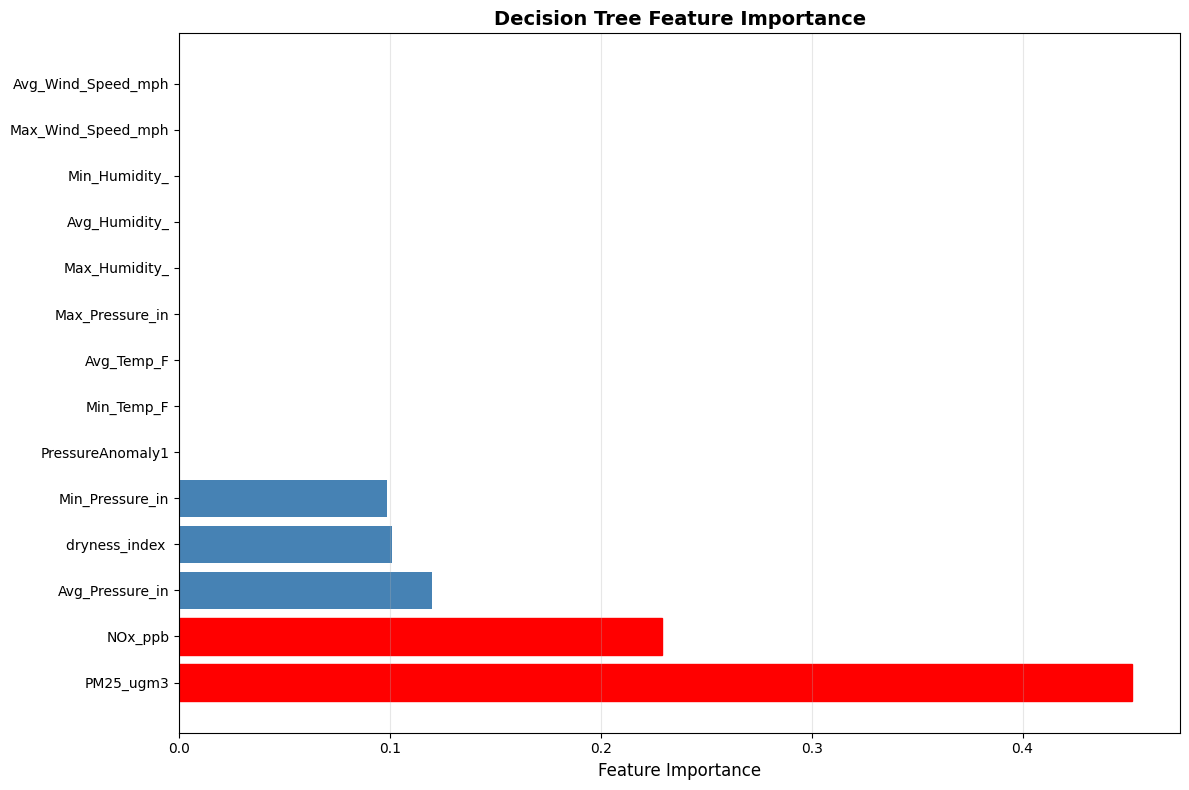

In [41]:
# Feature importance from the model vs entropy analysis
feature_importance = pd.DataFrame({
    'Feature': features_to_use,
    'Model_Importance': dt_model.feature_importances_,
    'Entropy_Rank': range(1, len(features_to_use) + 1)
}).sort_values('Model_Importance', ascending=False)

print("="*80)
print("FEATURE IMPORTANCE COMPARISON")
print("="*80)
print("\nModel Feature Importance vs Entropy Analysis Ranking:")
print(f"{'Feature':<25} | {'Model Importance':<18} | {'Entropy Rank':<12}")
print("-"*60)

for idx, row in feature_importance.iterrows():
    marker = " ***" if 'NOx' in row['Feature'] or 'PM25' in row['Feature'] else ""
    print(f"{row['Feature']:<25}{marker} | {row['Model_Importance']:>17.6f} | {int(row['Entropy_Rank']):>12d}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(feature_importance)), feature_importance['Model_Importance'], 
                color='steelblue')
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Decision Tree Feature Importance', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Highlight top features from entropy analysis
for i, (idx, row) in enumerate(feature_importance.iterrows()):
    if 'NOx' in row['Feature'] or 'PM25' in row['Feature']:
        bars[i].set_color('red')

plt.tight_layout()
plt.show()


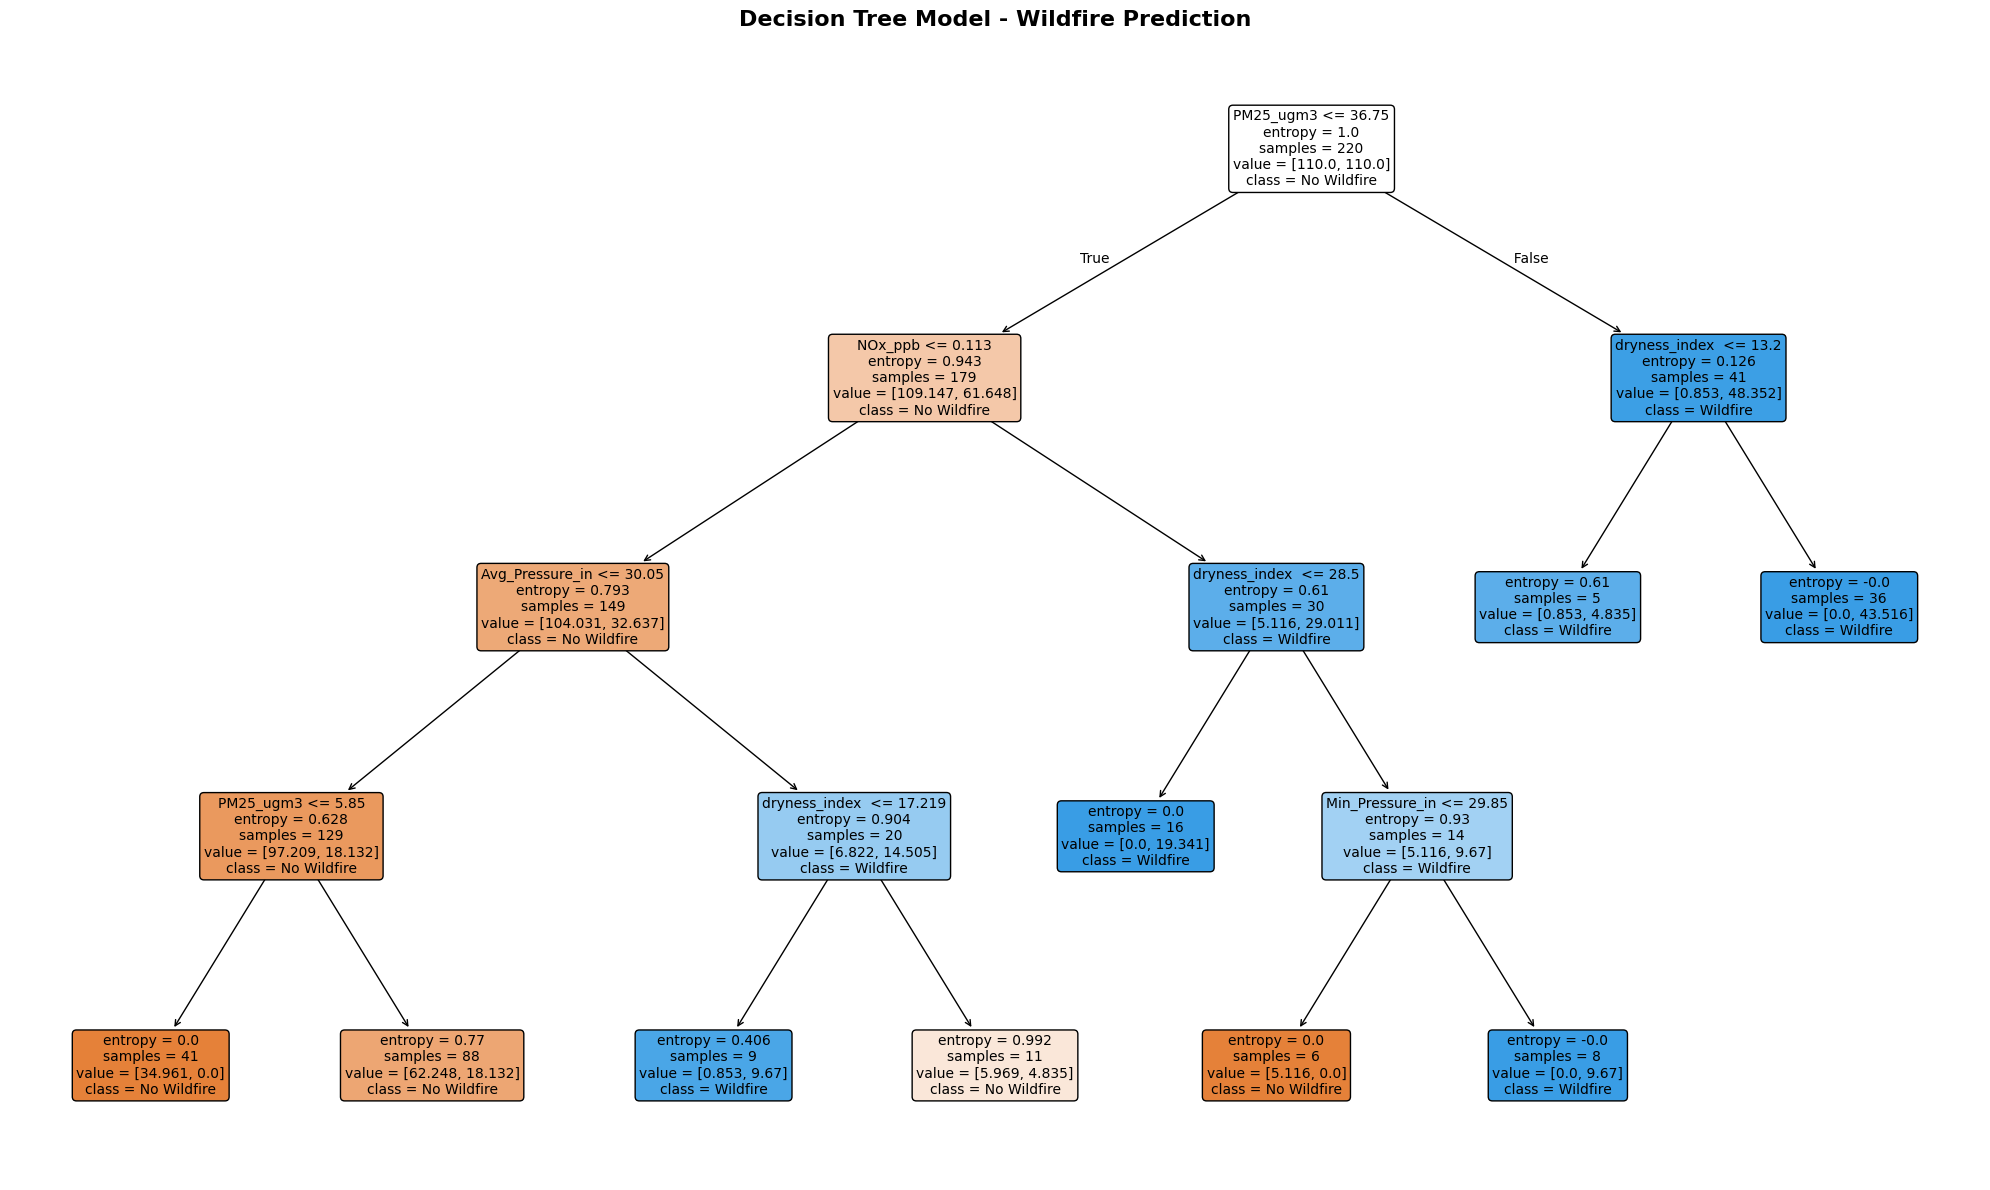

DECISION TREE STRUCTURE SUMMARY

Tree Depth: 4
Number of Leaves: 9
Number of Features Used: 5


In [42]:
# Visualize the decision tree
plt.figure(figsize=(20, 12))
plot_tree(dt_model, 
          feature_names=features_to_use,
          class_names=['No Wildfire', 'Wildfire'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Decision Tree Model - Wildfire Prediction', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print tree structure
print("="*80)
print("DECISION TREE STRUCTURE SUMMARY")
print("="*80)
print(f"\nTree Depth: {dt_model.get_depth()}")
print(f"Number of Leaves: {dt_model.get_n_leaves()}")
print(f"Number of Features Used: {np.sum(dt_model.feature_importances_ > 0)}")


DETAILED PERFORMANCE METRICS

Classification Report - Test Set:
              precision    recall  f1-score   support

 No Wildfire       0.82      0.97      0.89        33
    Wildfire       0.94      0.70      0.80        23

    accuracy                           0.86        56
   macro avg       0.88      0.83      0.84        56
weighted avg       0.87      0.86      0.85        56


Confusion Matrix:
                 Predicted
              No WF   Wildfire
Actual No WF     32       1
       Wildfire     7      16


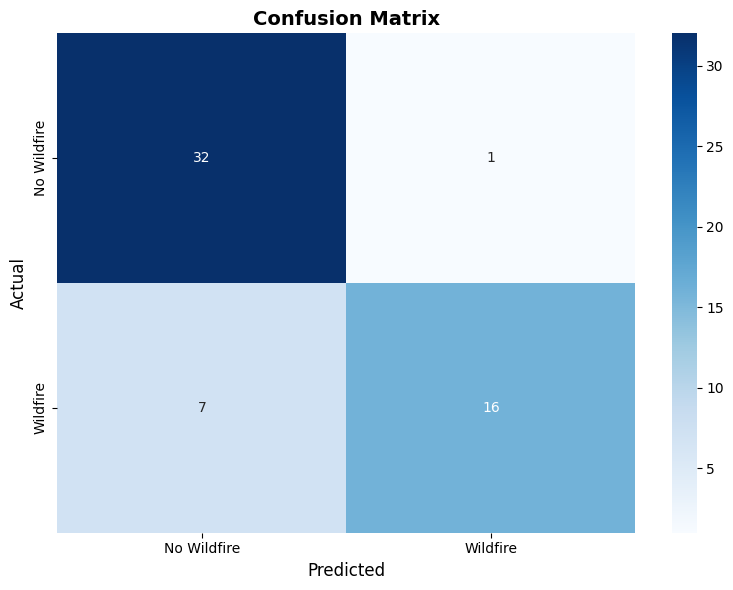


Detailed Metrics:
  Precision: 0.9412
  Recall (Sensitivity): 0.6957
  F1-Score: 0.8000


In [43]:
# Detailed performance metrics
print("="*80)
print("DETAILED PERFORMANCE METRICS")
print("="*80)

print("\nClassification Report - Test Set:")
print(classification_report(y_test, y_test_pred, 
                           target_names=['No Wildfire', 'Wildfire']))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:")
print(f"                 Predicted")
print(f"              No WF   Wildfire")
print(f"Actual No WF  {cm[0,0]:5d}   {cm[0,1]:5d}")
print(f"       Wildfire {cm[1,0]:5d}   {cm[1,1]:5d}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Wildfire', 'Wildfire'],
            yticklabels=['No Wildfire', 'Wildfire'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate metrics
true_negatives = cm[0, 0]
false_positives = cm[0, 1]
false_negatives = cm[1, 0]
true_positives = cm[1, 1]

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nDetailed Metrics:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall (Sensitivity): {recall:.4f}")
print(f"  F1-Score: {f1_score:.4f}")


In [44]:
# Import necessary libraries for decision path analysis
import numpy as np
import pandas as pd

# Decision tree decision path analysis
# Show the actual decision rules for key paths
print("="*80)
print("KEY DECISION PATHS IN THE TREE")
print("="*80)

# Check if model has been trained
if not hasattr(dt_model, 'tree_') and not hasattr(dt_model, '_tree'):
    print("\nERROR: Model has not been trained yet. Please run cell 4 first.")
else:
    # Get the tree structure (compatible with different sklearn versions)
    try:
        tree = dt_model.tree_
    except AttributeError:
        tree = dt_model._tree
    
    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    threshold = tree.threshold
    value = tree.value

    def get_path(node, depth=0, path="", max_depth=3):
        """Recursively get decision paths"""
        if depth > max_depth:
            return
        indent = "  " * depth
        if children_left[node] == children_right[node]:  # Leaf node
            samples = int(value[node].sum())
            class_dist = value[node][0]
            pred_class = int(np.argmax(class_dist))
            confidence = class_dist[pred_class] / class_dist.sum()
            print(f"{indent}→ Leaf: Predict {'Wildfire' if pred_class == 1 else 'No Wildfire'}")
            print(f"{indent}  Samples: {samples}, Confidence: {confidence:.2%}")
            return
        else:  # Decision node
            feat_idx = feature[node]
            if feat_idx >= 0:  # Valid feature index
                feat_name = features_to_use[feat_idx]
                thresh = threshold[node]
                print(f"{indent}Node {node}: {feat_name} <= {thresh:.4f}")
                get_path(children_left[node], depth + 1, path + f" {feat_name} <= {thresh:.4f}", max_depth)
                print(f"{indent}Node {node}: {feat_name} > {thresh:.4f}")
                get_path(children_right[node], depth + 1, path + f" {feat_name} > {thresh:.4f}", max_depth)

    # Show first few levels
    print("\nDecision Tree Paths (first 3 levels):")
    get_path(0, depth=0, max_depth=3)


KEY DECISION PATHS IN THE TREE

Decision Tree Paths (first 3 levels):
Node 0: PM25_ugm3 <= 36.7500
  Node 1: NOx_ppb <= 0.1135
    Node 2: Avg_Pressure_in <= 30.0500
      Node 3: PM25_ugm3 <= 5.8500
      Node 3: PM25_ugm3 > 5.8500
    Node 2: Avg_Pressure_in > 30.0500
      Node 6: dryness_index  <= 17.2185
      Node 6: dryness_index  > 17.2185
  Node 1: NOx_ppb > 0.1135
    Node 9: dryness_index  <= 28.5000
      → Leaf: Predict Wildfire
        Samples: 1, Confidence: 100.00%
    Node 9: dryness_index  > 28.5000
      Node 11: Min_Pressure_in <= 29.8500
      Node 11: Min_Pressure_in > 29.8500
Node 0: PM25_ugm3 > 36.7500
  Node 14: dryness_index  <= 13.2000
    → Leaf: Predict Wildfire
      Samples: 0, Confidence: 85.01%
  Node 14: dryness_index  > 13.2000
    → Leaf: Predict Wildfire
      Samples: 1, Confidence: 100.00%


In [45]:
# Import necessary libraries for tree structure analysis
import numpy as np

# Summary of Decision Tree Layers
print("="*80)
print("DECISION TREE LAYERS SUMMARY")
print("="*80)

# Check if model has been trained
if not hasattr(dt_model, 'tree_') and not hasattr(dt_model, '_tree'):
    print("\nERROR: Model has not been trained yet. Please run cell 4 first.")
else:
    # Get the tree structure (compatible with different sklearn versions)
    try:
        tree = dt_model.tree_
    except AttributeError:
        tree = dt_model._tree
    
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    threshold = tree.threshold
    value = tree.value

    # Get simplified tree structure
    def print_tree_structure(node, depth=0, max_depth=3):
        """Print tree structure up to max_depth"""
        if depth > max_depth:
            return
        
        indent = "  " * depth
        
        if children_left[node] == children_right[node]:  # Leaf
            samples = int(value[node].sum())
            class_dist = value[node][0]
            pred_class = int(np.argmax(class_dist))
            confidence = class_dist[pred_class] / class_dist.sum()
            print(f"{indent}→ {'Wildfire' if pred_class == 1 else 'No Wildfire'} (n={samples}, conf={confidence:.1%})")
        else:
            feat_idx = feature[node]
            if feat_idx >= 0:  # Valid feature index
                feat_name = features_to_use[feat_idx]
                thresh = threshold[node]
                print(f"{indent}Layer {depth+1}: {feat_name} <= {thresh:.4f}")
                print_tree_structure(children_left[node], depth + 1, max_depth)
                print(f"{indent}Layer {depth+1}: {feat_name} > {thresh:.4f}")
                print_tree_structure(children_right[node], depth + 1, max_depth)

    print("\nDecision Tree Structure (first 3 layers):")
    print_tree_structure(0, depth=0, max_depth=3)

    print("\n" + "="*80)
    print("FEATURE USAGE SUMMARY")
    print("="*80)
    features_used = [features_to_use[i] for i in feature if i >= 0]
    unique_features = set(features_used)
    print(f"\nUnique features used in tree: {len(unique_features)}")
    for i, feat in enumerate(sorted(unique_features), 1):
        usage_count = features_used.count(feat)
        if feat in features_to_use:
            importance = dt_model.feature_importances_[features_to_use.index(feat)]
            print(f"  {i}. {feat}: Used {usage_count} time(s), Importance: {importance:.4f}")


DECISION TREE LAYERS SUMMARY

Decision Tree Structure (first 3 layers):
Layer 1: PM25_ugm3 <= 36.7500
  Layer 2: NOx_ppb <= 0.1135
    Layer 3: Avg_Pressure_in <= 30.0500
      Layer 4: PM25_ugm3 <= 5.8500
      Layer 4: PM25_ugm3 > 5.8500
    Layer 3: Avg_Pressure_in > 30.0500
      Layer 4: dryness_index  <= 17.2185
      Layer 4: dryness_index  > 17.2185
  Layer 2: NOx_ppb > 0.1135
    Layer 3: dryness_index  <= 28.5000
      → Wildfire (n=1, conf=100.0%)
    Layer 3: dryness_index  > 28.5000
      Layer 4: Min_Pressure_in <= 29.8500
      Layer 4: Min_Pressure_in > 29.8500
Layer 1: PM25_ugm3 > 36.7500
  Layer 2: dryness_index  <= 13.2000
    → Wildfire (n=0, conf=85.0%)
  Layer 2: dryness_index  > 13.2000
    → Wildfire (n=1, conf=100.0%)

FEATURE USAGE SUMMARY

Unique features used in tree: 5
  1. Avg_Pressure_in: Used 1 time(s), Importance: 0.1197
  2. Min_Pressure_in: Used 1 time(s), Importance: 0.0985
  3. NOx_ppb: Used 1 time(s), Importance: 0.2288
  4. PM25_ugm3: Used 2 time(

In [46]:
# Model Summary and Final Statistics
print("="*80)
print("MODEL SUMMARY")
print("="*80)

if hasattr(dt_model, 'tree_') or hasattr(dt_model, '_tree'):
    print(f"\nModel successfully trained!")
    print(f"Dataset size: {len(df)} samples")
    print(f"Training set: {len(X_train)} samples")
    print(f"Test set: {len(X_test)} samples")
    print(f"\nTraining Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
    print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"\nTree Depth: {dt_model.get_depth()}")
    print(f"Number of Leaves: {dt_model.get_n_leaves()}")
    print(f"Number of Features Used: {np.sum(dt_model.feature_importances_ > 0)}")
    
    print(f"\nTop 5 Most Important Features:")
    top_features = pd.DataFrame({
        'Feature': features_to_use,
        'Importance': dt_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(5)
    
    for idx, row in top_features.iterrows():
        print(f"  {row['Feature']}: {row['Importance']:.4f}")
    
    print(f"\nOverall Data Distribution:")
    print(f"  Wildfire days (yn=1): {(df['yn'] == 1).sum()} ({(df['yn'] == 1).sum()/len(df)*100:.1f}%)")
    print(f"  No Wildfire days (yn=0): {(df['yn'] == 0).sum()} ({(df['yn'] == 0).sum()/len(df)*100:.1f}%)")
    
    print(f"\nFeatures used in model:")
    features_used_in_tree = [features_to_use[i] for i in range(len(features_to_use)) 
                             if dt_model.feature_importances_[i] > 0]
    print(f"  {', '.join(features_used_in_tree)}")
else:
    print("\nModel has not been trained yet. Please run cells 1-4 first.")

MODEL SUMMARY

Model successfully trained!
Dataset size: 276 samples
Training set: 220 samples
Test set: 56 samples

Training Accuracy: 0.9045 (90.45%)
Test Accuracy: 0.8571 (85.71%)

Tree Depth: 4
Number of Leaves: 9
Number of Features Used: 5

Top 5 Most Important Features:
  PM25_ugm3: 0.4521
  NOx_ppb: 0.2288
  Avg_Pressure_in: 0.1197
  dryness_index : 0.1009
  Min_Pressure_in: 0.0985

Overall Data Distribution:
  Wildfire days (yn=1): 114 (41.3%)
  No Wildfire days (yn=0): 162 (58.7%)

Features used in model:
  NOx_ppb, PM25_ugm3, Avg_Pressure_in, Min_Pressure_in, dryness_index 


In [47]:
# Import pandas with a different alias to avoid conflicts  
# Note: pd is already imported in cell 1, but we'll use pandas_df for clarity
import pandas as pandas_df
import numpy as np

# Test the model on unseen data from madre_fire_test.csv
print("="*80)
print("EVALUATING MODEL ON UNSEEN TEST DATA")
print("="*80)

# Load the test dataset
test_df = pandas_df.read_csv("/home/aveb7tacoma/engr697/data/madre_fire_test.csv")
test_df['Date'] = pandas_df.to_datetime(test_df['Date'])

print(f"\nTest dataset loaded successfully!")
print(f"Test dataset shape: {test_df.shape}")
print(f"\nTest dataset columns:")
print(test_df.columns.tolist())

# Check if target variable exists
if 'yn' in test_df.columns:
    print(f"\nTarget variable distribution in test data:")
    print(test_df['yn'].value_counts())
    print(f"\nTarget variable percentage:")
    print(test_df['yn'].value_counts(normalize=True) * 100)
else:
    print("\nWARNING: 'yn' column not found in test data. Will need to create it or use different evaluation.")

EVALUATING MODEL ON UNSEEN TEST DATA

Test dataset loaded successfully!
Test dataset shape: (31, 23)

Test dataset columns:
['Date', 'Max_Temp_F', 'Avg_Temp_F', 'Min_Temp_F', 'Max_Humidity_', 'Avg_Humidity_', 'Min_Humidity_', 'Max_Wind_Speed_mph', 'Avg_Wind_Speed_mph', 'Min_Wind_Speed_mph', 'Max_Pressure_in', 'Avg_Pressure_in', 'Min_Pressure_in', 'PM25_ugm3', 'CO2_ppm', 'yn', 'City', 'Climate', 'NOx_ppb', 'dryness_index ', 'dispersion_ratio', 'PressureAnomaly1', 'pm2.5 difference']

Target variable distribution in test data:
yn
1    25
0     6
Name: count, dtype: int64

Target variable percentage:
yn
1    80.645161
0    19.354839
Name: proportion, dtype: float64


In [ ]:
# Prepare test features (same as training)
# Check if test_df exists (from cell 11)
if 'test_df' not in globals():
    print("ERROR: test_df not found. Please run cell 11 first to load the test data.")
else:
    # Use the same features_to_use list from cell 2
    X_test_unseen = test_df[features_to_use].copy()
    
    # Convert all feature columns to numeric, replacing any non-numeric values with NaN
    print("Preparing test features...")
    for col in X_test_unseen.columns:
        X_test_unseen[col] = pandas_df.to_numeric(X_test_unseen[col], errors='coerce')
    
    # Handle any missing values (use median from training data if available)
    print(f"\nMissing values in test features:")
    missing = X_test_unseen.isna().sum()
    if missing.sum() > 0:
        print(missing[missing > 0])
        # Fill missing values with median from training data (X)
        for col in X_test_unseen.columns:
            if X_test_unseen[col].isna().sum() > 0:
                # Use training data median if available, otherwise use test median
                if col in X.columns:
                    X_test_unseen[col] = X_test_unseen[col].fillna(X[col].median())
                else:
                    X_test_unseen[col] = X_test_unseen[col].fillna(X_test_unseen[col].median())
        print("Filled missing values with training medians")
    else:
        print("No missing values!")
    
    # Ensure all columns are numeric
    X_test_unseen = X_test_unseen.select_dtypes(include=[np.number])
    
    print(f"\nTest feature matrix shape: {X_test_unseen.shape}")
    print(f"Features used: {list(X_test_unseen.columns)}")
    
    # Check if we have the target variable
    if 'yn' in test_df.columns:
        y_test_unseen = test_df['yn'].copy()
        print(f"\nTest target vector shape: {y_test_unseen.shape}")
        print(f"Target variable distribution:")
        print(y_test_unseen.value_counts())
    else:
        print("\nWARNING: No target variable 'yn' in test data.")
        y_test_unseen = None

Preparing test features...

Missing values in test features:
No missing values!

Test feature matrix shape: (31, 14)
Features used: ['NOx_ppb', 'PM25_ugm3', 'PressureAnomaly1', 'Avg_Pressure_in', 'Avg_Temp_F', 'Min_Temp_F', 'Max_Humidity_', 'Min_Pressure_in', 'Max_Pressure_in', 'Avg_Humidity_', 'Min_Humidity_', 'Max_Wind_Speed_mph', 'Avg_Wind_Speed_mph', 'dryness_index ']

Test target vector shape: (31,)
Target variable distribution:
yn
1    25
0     6
Name: count, dtype: int64


MAKING PREDICTIONS ON UNSEEN TEST DATA

Predictions made on 31 test samples

Predicted class distribution:
  Class 0 (No Wildfire): 31 samples (100.0%)

TEST DATA EVALUATION RESULTS

Test Accuracy: 0.1935 (19.35%)

Training Accuracy: 0.9045 (90.45%)
Original Test Accuracy: 0.8571 (85.71%)
Unseen Test Accuracy: 0.1935 (19.35%)

Classification Report:
              precision    recall  f1-score   support

 No Wildfire       0.19      1.00      0.32         6
    Wildfire       0.00      0.00      0.00        25

    accuracy                           0.19        31
   macro avg       0.10      0.50      0.16        31
weighted avg       0.04      0.19      0.06        31


Confusion Matrix:
                 Predicted
              No WF   Wildfire
Actual No WF      6       0
       Wildfire    25       0

Detailed Metrics:
  Precision: 0.0000
  Recall (Sensitivity): 0.0000
  F1-Score: 0.0000


/home/aveb7tacoma/engr697/env697/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/aveb7tacoma/engr697/env697/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/aveb7tacoma/engr697/env697/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital

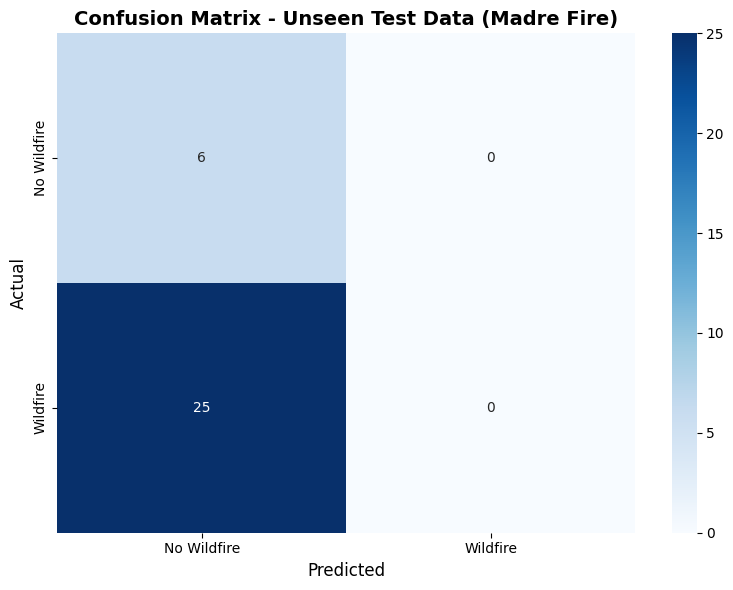

In [ ]:
# Make predictions on unseen test data
print("="*80)
print("MAKING PREDICTIONS ON UNSEEN TEST DATA")
print("="*80)

# Check if model exists and test data is prepared
if 'dt_model' not in globals() or dt_model is None:
    print("\nERROR: Model not found. Please run cells 1-4 to train the model first.")
elif 'X_test_unseen' not in globals():
    print("\nERROR: Test data not prepared. Please run cells 11-12 first to load and prepare the test data.")
else:
    # Make predictions
    y_test_pred_unseen = dt_model.predict(X_test_unseen)
    
    # Get prediction probabilities
    y_test_proba_unseen = dt_model.predict_proba(X_test_unseen)
    
    print(f"\nPredictions made on {len(X_test_unseen)} test samples")
    print(f"\nPredicted class distribution:")
    unique, counts = np.unique(y_test_pred_unseen, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"  Class {cls} ({'Wildfire' if cls == 1 else 'No Wildfire'}): {count} samples ({count/len(y_test_pred_unseen)*100:.1f}%)")
    
    # If we have true labels, calculate accuracy and other metrics
    if y_test_unseen is not None:
        from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
        
        test_accuracy_unseen = accuracy_score(y_test_unseen, y_test_pred_unseen)
        
        print(f"\n{'='*80}")
        print("TEST DATA EVALUATION RESULTS")
        print(f"{'='*80}")
        print(f"\nTest Accuracy: {test_accuracy_unseen:.4f} ({test_accuracy_unseen*100:.2f}%)")
        
        # Compare with training/test accuracies if available
        if 'train_accuracy' in globals() and 'test_accuracy' in globals():
            print(f"\nTraining Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
            print(f"Original Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
            print(f"Unseen Test Accuracy: {test_accuracy_unseen:.4f} ({test_accuracy_unseen*100:.2f}%)")
        
        # Classification report
        print(f"\nClassification Report:")
        print(classification_report(y_test_unseen, y_test_pred_unseen, 
                                   target_names=['No Wildfire', 'Wildfire']))
        
        # Confusion matrix
        cm_unseen = confusion_matrix(y_test_unseen, y_test_pred_unseen)
        print(f"\nConfusion Matrix:")
        print(f"                 Predicted")
        print(f"              No WF   Wildfire")
        print(f"Actual No WF  {cm_unseen[0,0]:5d}   {cm_unseen[0,1]:5d}")
        print(f"       Wildfire {cm_unseen[1,0]:5d}   {cm_unseen[1,1]:5d}")
        
        # Calculate detailed metrics
        true_negatives = cm_unseen[0, 0]
        false_positives = cm_unseen[0, 1]
        false_negatives = cm_unseen[1, 0]
        true_positives = cm_unseen[1, 1]
        
        precision_unseen = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall_unseen = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1_score_unseen = 2 * (precision_unseen * recall_unseen) / (precision_unseen + recall_unseen) if (precision_unseen + recall_unseen) > 0 else 0
        
        print(f"\nDetailed Metrics:")
        print(f"  Precision: {precision_unseen:.4f}")
        print(f"  Recall (Sensitivity): {recall_unseen:.4f}")
        print(f"  F1-Score: {f1_score_unseen:.4f}")
        
        # Visualize confusion matrix
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_unseen, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['No Wildfire', 'Wildfire'],
                    yticklabels=['No Wildfire', 'Wildfire'])
        plt.title('Confusion Matrix - Unseen Test Data (Madre Fire)', fontsize=14, fontweight='bold')
        plt.ylabel('Actual', fontsize=12)
        plt.xlabel('Predicted', fontsize=12)
        plt.tight_layout()
        plt.show()
        
    else:
        print("\nNo ground truth labels available. Showing predictions only:")
        print(f"\nFirst 10 predictions:")
        for i in range(min(10, len(y_test_pred_unseen))):
            prob = y_test_proba_unseen[i]
            pred = y_test_pred_unseen[i]
            print(f"  Sample {i+1}: Predicted = {pred} ({'Wildfire' if pred == 1 else 'No Wildfire'}), "
                  f"Confidence = {prob[pred]:.2%}")